In [1]:
import pandas as pd
import numpy as np



In [2]:
from rec_gym.envs import MovieLensDRR, MovieLens100

In [3]:
from rec_gym.wrappers import BaselinesWrapper, DRR_BaselinesWrapper, StatsWrapper

In [4]:
import tqdm

In [5]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [10]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def _reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

In [11]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [12]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [13]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.tanh(self.linear1(state))
        x = F.tanh(self.linear2(x))
        x = self.linear3(x)
        x = F.softmax(x)
#         x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).to(device)#.unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()

In [14]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    ap = policy_net(state)
    policy_loss = value_net(state, ap)
    policy_loss = -policy_loss.mean() #+ (ap**2).mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
#     print(value_loss, policy_loss)
        
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    
    return policy_loss, value_loss

In [24]:
import pandas as pd
df = pd.read_csv('./ablation_ddpg', index_col=[0])
df['NDCG@10'].max()
# df

0.8164532805395224

In [26]:
df[df['Precision@10'] == df['Precision@10'].max()]

,alg,HIDDEN,REPLAY_SIZE,BATCH,Precision@5,Precision@10,Precision@15,Precision@20,NDCG@5,NDCG@10,NDCG@15,NDCG@20
7,ddpg,16,30000,64,0.640316,0.615148,0.588916,0.562161,0.745385,0.816453,0.904815,0.99233


In [25]:
df[df['NDCG@10'] == df['NDCG@10'].max()]

,alg,HIDDEN,REPLAY_SIZE,BATCH,Precision@5,Precision@10,Precision@15,Precision@20,NDCG@5,NDCG@10,NDCG@15,NDCG@20
7,ddpg,16,30000,64,0.640316,0.615148,0.588916,0.562161,0.745385,0.816453,0.904815,0.99233


In [74]:
# e = MovieLens100(
#                  n_items_to_recommend=1,
#                  env_seed=5,
#                  normalize_reward=False,
#                  session_time=None,
#                  session_size=20,
#                  shuffle_sessions=True,
#                  )

# e = StatsWrapper(e)
# e = DRR_BaselinesWrapper(e)

def make_env(session_size=10, seed=123):
#     env = MovieLens100(
#                  n_items_to_recommend=1,
#                  env_seed=seed,
#                  normalize_reward=False,
#                  session_time=None,
#                  session_size=session_size,
#                  shuffle_sessions=True,
#                  )  
    CACHE_DIR = "/home/anton/cache"
    
    
#     env = MovieLensDRR(embedding_dimension=20, 
#              n_items_to_recommend=1, 
#              env_seed=seed,
#              normalize_reward=True,
# #              filename="/home/anton/Datasets/MovieLens/ml-100k/u.data",
# #              sep='\t',
#              filename="/home/anton/Datasets/MovieLens/ml-1m/ratings.dat",\
#              sep='::',\
# #              session_time = 20 * 60,
#              session_size = session_size,
#              cache_dir=CACHE_DIR,
#              shuffle_sessions=False)
    
    env = MovieLensDRR(embedding_dimension=40, 
             n_items_to_recommend=1, 
             env_seed=seed,
             normalize_reward=True,
             filename="/home/anton/Datasets/MovieLens/ml-100k/u.data",
             sep='\t',
    #              session_time = 20 * 60,
             session_size = session_size,
             cache_dir=CACHE_DIR,
             shuffle_sessions=True
                      )
    
    env = StatsWrapper(env)
    env = DRR_BaselinesWrapper(env)
    return env

envs_kv = { 
    'ml_100k_s20_seed' : lambda x: make_env(20, x), 
    'ml_100k_s30_seed' : lambda x: make_env(30, x) 
             }

import tqdm
from collections import defaultdict

In [75]:
HIDDEN_SIZE = 32
BUFFER_SIZE = 1000
TRAIN_STEPS = 80000
EVAL_STEPS = 19000

TRAIN_EACH = 100
BATCH_SIZE = 64

In [76]:
actions = defaultdict(lambda : defaultdict(list))

In [77]:
import itertools

HIDDEN_SIZE_RANGE = [16] #[16, 32, 64, 128, 256]
BATCH_SIZE_RANGE = [64] #[32, 64, 128, 256]
BUFFER_SIZE =  [30000] # [1000, 10000, 20000, 30000]

In [78]:
results = defaultdict(defaultdict)
data = []

for HIDDEN_SIZE, BATCH_SIZE, BUFFER_SIZE in tqdm.tqdm_notebook(itertools.product(HIDDEN_SIZE_RANGE, BATCH_SIZE_RANGE, BUFFER_SIZE)):

    for name, env_fn in envs_kv.items():
        
        for x in [100]:#, 200, 300, 400, 500]:
        
            policy_losses = []
            value_losses = []
            env = env_fn(x)

            ou_noise = OUNoise(env.action_space)

            state_dim  = env.observation_space.shape[0]
            action_dim = env.action_space.shape[0]
            hidden_dim = HIDDEN_SIZE

            value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
            policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

            target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
            target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

            for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(param.data)

            for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(param.data)


            value_lr  = 1e-4
            policy_lr = 1e-3

            value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
            policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

            value_criterion = nn.MSELoss()

            replay_buffer_size = BUFFER_SIZE
            replay_buffer = ReplayBuffer(replay_buffer_size)


            obs0 = env.reset()

            for i in tqdm.tqdm_notebook(range(TRAIN_STEPS)):

                action = env.unwrapped.get_ground_truth_action(emb=True).embedding

                obs1, reward, terminal1, info = env.step(action)

            #     model._store_transition(obs0, action, reward, obs1, terminal1)

                replay_buffer.push(state=obs0[0], action=action, 
                                   reward=reward, next_state=obs1[0], done=terminal1)

                batch_size = BATCH_SIZE
                if i % TRAIN_EACH == 0:
                    if len(replay_buffer) > batch_size:
                        pl, vl = ddpg_update(batch_size)
                        policy_losses.append(pl)
                        value_losses.append(vl)

                if terminal1:
                    obs0 = env.reset()
                else:
                    obs0 = obs1


        #     for i in tqdm.tqdm_notebook(range(100)):
        #         ddpg_update(batch_size=64)

            for i in tqdm.tqdm_notebook(range(EVAL_STEPS)):
                a = policy_net.get_action(obs0)[0]
                actions[name]['ddpg_{}_{}_{}'.format(HIDDEN_SIZE, BUFFER_SIZE, BATCH_SIZE)].append(a)
                obs1, reward, terminal1, info = env.step(a)

                if terminal1:
                    obs0 = env.reset()
                else:
                    obs0 = obs1

            results[name]['ddpg_{}_{}_{}'.format(HIDDEN_SIZE, BUFFER_SIZE, BATCH_SIZE)] = env.env.interactions

            data.append(['ddpg', HIDDEN_SIZE, BUFFER_SIZE, BATCH_SIZE, TRAIN_EACH])
#             plt.figure()
#             plt.plot(policy_losses)
#             plt.title('policy loss')

#             plt.figure()
#             plt.plot(value_losses)
#             plt.title('value loss')

#             plt.show()

User cache /home/anton/cache/40_s_20_100_ml-100k_u.data
shuffle sessions


/home/anton/anaconda3/envs/datascience/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/anton/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


User cache /home/anton/cache/40_s_30_100_ml-100k_u.data
shuffle sessions


In [79]:
def precision_at_k(recs, gt, k):
    relevant_items = set(gt[:k])
    
    rec_rel = [item in relevant_items for item in recs[:k]]
    return np.mean(rec_rel)
    
    
def precision_at_k_thresh(rewards, k, threshold=0.):
    rec_rel = [r >= threshold for r in rewards[:k]]
    return np.mean(rec_rel)

def dcg_at_k(rewards, k):
    dcg = 0
    for i, r in enumerate(rewards[:k]):
        if i == 0:
            dcg += r
        else:
            dcg += 2**r - 1 / np.log2(i+1)
    return dcg

def ndcg_at_k(rewards, k):
    maxdcg = dcg_at_k(np.sort(rewards)[::-1], k)
    if maxdcg == 0: return 0
    return dcg_at_k(rewards, k) / maxdcg

In [80]:
from collections import defaultdict
THRESH = 0.5

In [81]:
all_metrics = defaultdict(lambda: defaultdict(dict))

for THRESH in [0.5]:

    for dataset_name in results:
        for i, algorithm in enumerate(results[dataset_name]):
            metrics = {}

            interactions = results[dataset_name][algorithm]
            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[TRAIN_STEPS:]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)


            for K in [5, 10, 15, 20]:

                precisions = []
                precisions_thresh = []
                ndcgs = []

                for k, v in session_recs_by_user.items():
                    for session_number in v:

                        recs = session_recs_by_user[k][session_number]
                        gt = session_gt_by_user[k][session_number]
                        rew = session_rewards_by_user[k][session_number]

                        p_at_k = precision_at_k(recs, gt, K)
                        precisions.append(p_at_k)

                        precisions_thresh.append(precision_at_k_thresh(rew, K, THRESH))

                        ndcgs.append(ndcg_at_k(np.array(rew)>=THRESH, K))


                metrics['NDCG@{}'.format(K)] = np.mean(ndcgs)
                metrics['Precision@{}'.format(K)] = np.mean(precisions_thresh)


            all_metrics[dataset_name][algorithm] = metrics

    metrics_by_algorithm = defaultdict(lambda: defaultdict(list))

    for dataset in all_metrics:
        print(dataset)
        for algorithm in all_metrics[dataset]:

            for k, v in all_metrics[dataset][algorithm].items():

                metrics_by_algorithm[algorithm][k].append(v)

        metrics_names = []
        for n in [5, 10, 15, 20]:
            metrics_names.append('Precision@{}'.format(n))
        for n in [5, 10, 15, 20]:
            metrics_names.append('NDCG@{}'.format(n))


        s = ['{:12s}'.format('')] + [ "{:12s}".format(m) for m in metrics_names]
        print('|'.join(s))

        for k in metrics_by_algorithm:
            s = ['{:12s}'.format(k)]
            for m in metrics_names:
                s.append("{:1.2f} +-{:1.3f}".format(np.mean(metrics_by_algorithm[k][m]), 
                                                     np.std(metrics_by_algorithm[k][m])))

            print('|'.join(s))

    

ml_100k_s20_seed
            |Precision@5 |Precision@10|Precision@15|Precision@20|NDCG@5      |NDCG@10     |NDCG@15     |NDCG@20     
ddpg_16_30000_64|0.64 +-0.000|0.62 +-0.000|0.59 +-0.000|0.56 +-0.000|0.75 +-0.000|0.82 +-0.000|0.90 +-0.000|0.99 +-0.000
ml_100k_s30_seed
            |Precision@5 |Precision@10|Precision@15|Precision@20|NDCG@5      |NDCG@10     |NDCG@15     |NDCG@20     
ddpg_16_30000_64|0.62 +-0.025|0.60 +-0.020|0.58 +-0.010|0.56 +-0.001|0.72 +-0.022|0.79 +-0.031|0.85 +-0.051|0.93 +-0.064


In [48]:
data = [] 
for k in metrics_by_algorithm:
    row = k.split('_')
    for m in metrics_names:
        row.append( np.mean(metrics_by_algorithm[k][m] )) 
    data.append(row)

In [49]:
columns = ['alg', 'HIDDEN', 'REPLAY_SIZE', 'BATCH'] + metrics_names
df = pd.DataFrame(data=data, columns=columns)

In [50]:
df.head()

,alg,HIDDEN,REPLAY_SIZE,BATCH,Precision@5,Precision@10,Precision@15,Precision@20,NDCG@5,NDCG@10,NDCG@15,NDCG@20
0,ddpg,16,1000,32,0.591419,0.580345,0.567759,0.562063,0.706962,0.790469,0.887790,0.992292
1,ddpg,16,10000,32,0.621716,0.590987,0.568654,0.562114,0.730281,0.798208,0.888529,0.992292
2,ddpg,16,20000,32,0.634180,0.605848,0.579264,0.562063,0.741247,0.809519,0.897738,0.992292
3,ddpg,16,30000,32,0.634180,0.605848,0.579136,0.562063,0.741247,0.809519,0.897624,0.992292
4,ddpg,16,1000,64,0.621716,0.590700,0.568718,0.562114,0.730281,0.797992,0.888568,0.992292


In [58]:
df[['HIDDEN', 'REPLAY_SIZE', 'BATCH']] =  df[['HIDDEN', 'REPLAY_SIZE', 'BATCH']].astype(int)

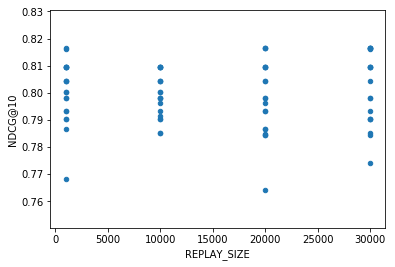

In [64]:
df.plot(x='REPLAY_SIZE', y='NDCG@10', kind='scatter')

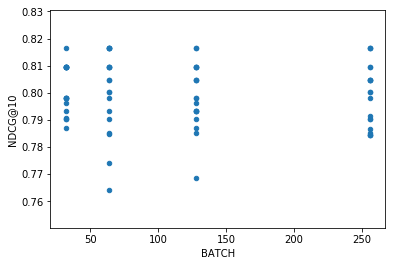

In [65]:
df.plot(x='BATCH', y='NDCG@10', kind='scatter')

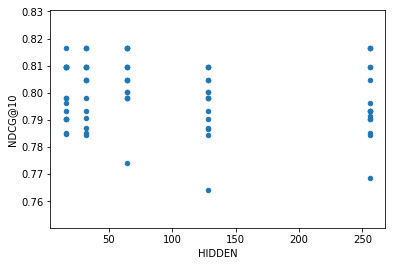

In [66]:
df.plot(x='HIDDEN', y='NDCG@10', kind='scatter')

In [62]:
import seaborn as sns

In [76]:
df['HIDDEN'].unique()

array([ 16,  32,  64, 128, 256])

In [83]:
# df.to_csv('ablation_ddpg')

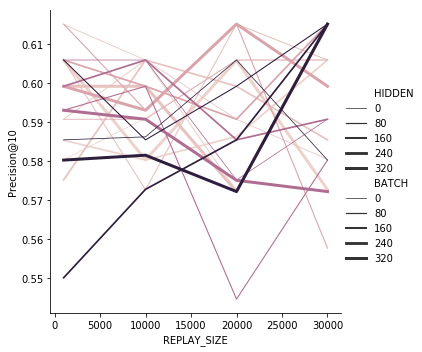

In [77]:
sns.relplot(x="REPLAY_SIZE", y="Precision@10",
            size="BATCH", hue="HIDDEN",
            kind="line", data=df);

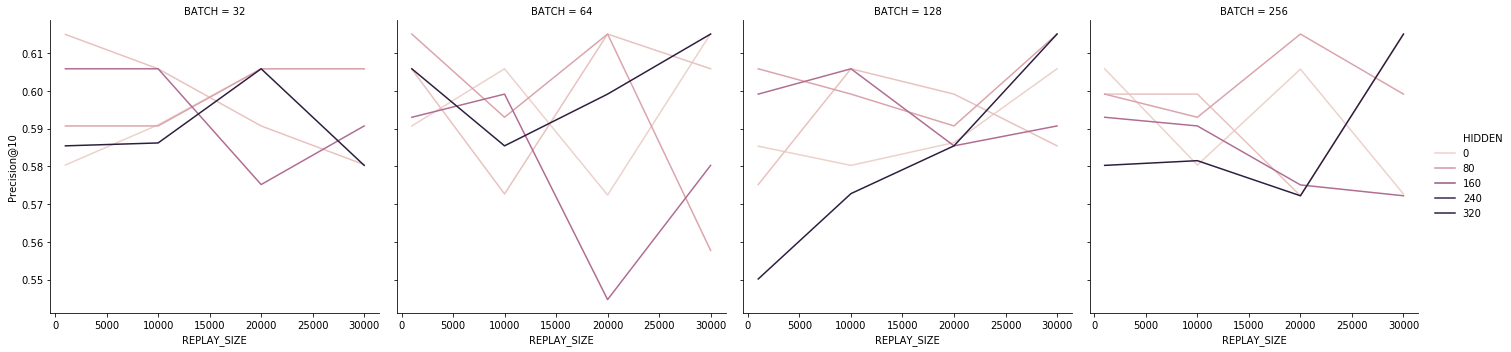

In [81]:

sns.relplot(x="REPLAY_SIZE", y="Precision@10", hue="HIDDEN",
            col="BATCH",
            kind="line", estimator=None, data=df);

In [22]:
results['ml_100k_s20_seed100']['ddpg_16_1000_32'][TRAIN_STEPS:]

[Interaction(t=80001, uid=121, recs=[1077], rewards=[1.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [1.0], 'recs': [1077], 'ground_truth_items': [177], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 121}),
 Interaction(t=80002, uid=121, recs=[369], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [369], 'ground_truth_items': [1077], 'ground_truth_rewards': array([4]), 'norm_truth_rewards': [0.5], 'uid': 121}),
 Interaction(t=80003, uid=121, recs=[177], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [177], 'ground_truth_items': [145], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 121}),
 Interaction(t=80004, uid=620, recs=[1006], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [1006], 'ground_truth_items': [863], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 620}),
 Intera

In [23]:
results['ml_100k_s20_seed100']['ddpg_16_1000_64'][TRAIN_STEPS:]

[Interaction(t=80001, uid=121, recs=[369], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [369], 'ground_truth_items': [177], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 121}),
 Interaction(t=80002, uid=121, recs=[1077], rewards=[1.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [1.0], 'recs': [1077], 'ground_truth_items': [1077], 'ground_truth_rewards': array([4]), 'norm_truth_rewards': [0.5], 'uid': 121}),
 Interaction(t=80003, uid=121, recs=[177], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [177], 'ground_truth_items': [145], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 121}),
 Interaction(t=80004, uid=620, recs=[1006], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [1006], 'ground_truth_items': [863], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 620}),
 Intera

In [ ]:
actions['ml_100k_s20_seed100']['ddpg_32_10000_32'][:3]


In [45]:
a1 = actions['ml_100k_s20_seed100']['ddpg_16_1000_32'][0]
a2 = actions['ml_100k_s20_seed100']['ddpg_16_1000_64'][0]

print(np.dot(a1, env.last_items[0].embedding ))
print(np.dot(a2, env.last_items[0].embedding ))


-0.12584302881337925
0.45869097235882583


In [46]:
unw = env.env.env

i = 3
print(np.dot(a1, unw.Items[i].embedding ))
print(np.dot(a2, unw.Items[i].embedding ))

0.5336211282416389
0.33960133525608843


In [53]:
scores = [ np.dot(a1, unw.Items[i].embedding ) for i in range(100) ]

print(scores)
a = np.argsort(scores)[::-1][:1]
a

[0.24387611032591588, 0.46894198624449973, 0.17208981265305162, 0.5336211282416389, 0.2537916246475437, 0.43408415387678284, 0.4448513412623629, 0.5818740033123194, 0.29165739066323176, 0.31081065459421814, 0.4650950604194019, 0.3276165288063039, 0.4328292280501181, 0.2117374973187758, 0.24638018972162548, 0.17768055902617777, 0.3891314982237906, 0.4770670657903074, 0.1580792878150335, 0.06595945119252793, 0.36688359584543484, 0.4011354666501451, 0.24384174190170615, 0.5630406005490072, 0.4810368175901208, 0.19379747499179664, 0.7326193715244336, 0.3321618949409996, 0.406922961390237, 0.4267335397298989, 0.28953998488078003, 0.2916893756414881, 0.40199178462095697, 0.7222031322532064, 0.4307789559635359, 0.14987419106008515, 0.38197018411202205, 0.22718543664981278, 0.24586650076454517, 0.3022990682234667, 0.5050364228646377, 0.47638300386431626, 0.12247640954614354, 0.09006613232477029, 0.15363839454887643, 0.18330895248543685, 0.4035808326409087, 0.287700562162862, 0.4096982932112783

array([26])

In [ ]:
actions['ml_100k_s20_seed100']['ddpg_32_1000_64'][:3]

In [ ]:
import sys
results['ml_100k_s30_seed100']['ddpg'][0]

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1.5) 


In [65]:
results

defaultdict(collections.defaultdict,
            {'ml_100k_s20_seed': defaultdict(None,
                         {'ddpg_16_30000_64': [Interaction(t=1, uid=880, recs=[36], rewards=[0.5], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.5], 'recs': [36], 'ground_truth_items': [332], 'ground_truth_rewards': array([4]), 'norm_truth_rewards': [0.5], 'uid': 880}),
                           Interaction(t=2, uid=880, recs=[408], rewards=[0.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [0.0], 'recs': [408], 'ground_truth_items': [549], 'ground_truth_rewards': array([4]), 'norm_truth_rewards': [0.5], 'uid': 880}),
                           Interaction(t=3, uid=880, recs=[767], rewards=[1.0], probs=None, best_ps=None, ranks=None, raw_info={'rewards': [1.0], 'recs': [767], 'ground_truth_items': [767], 'ground_truth_rewards': array([3]), 'norm_truth_rewards': [0.0], 'uid': 880}),
                           Interaction(t=4, uid=880, recs=[640], rewards=[1.0], probs=N

In [72]:
results.keys()

dict_keys(['ml_100k_s20_seed', 'ml_100k_s30_seed', 'ml_100k_s20_seed100'])

In [82]:
counts = defaultdict(lambda: defaultdict(int))

for name, interactions in results['ml_100k_s20_seed'].items():
    session_recs_by_user = defaultdict(lambda : defaultdict(list))
    session_gt_by_user = defaultdict(lambda : defaultdict(list))
    session_rewards_by_user = defaultdict(lambda : defaultdict(list))

    prev_user = None

    for i in interactions[TRAIN_STEPS:]:
        u = i.uid 
        recs = i.recs
        gt = i.raw_info['ground_truth_items']
        rewards = i.rewards

        if prev_user is None or u != prev_user:
            prev_user = u
            user_session = len(session_recs_by_user[prev_user])

        session_recs_by_user[prev_user][user_session].extend(recs)
        session_gt_by_user[prev_user][user_session].extend(gt)
        session_rewards_by_user[prev_user][user_session].extend(rewards)

    precisions = []
    precisions_thresh = []
    ndcgs = []

    for k, v in session_recs_by_user.items():
        for session_number in v:

            recs = session_recs_by_user[k][session_number][:20]

            for item in recs:
                counts[name][item] += 1

In [83]:
import cloudpickle

In [84]:
with open('ddpg_100k_counts_s20', 'wb') as f:
    cloudpickle.dump(counts, f)

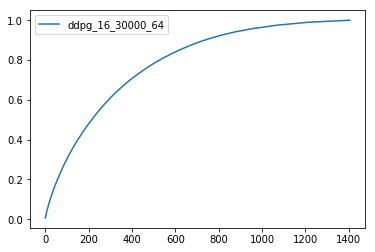

In [85]:
fig = plt.figure()
for name, c in counts.items():
    plt.plot(np.cumsum(np.sort(list(c.values()))[::-1])/np.sum(list(c.values())), label=name)
plt.legend()
plt.show();

# fig.savefig('ddpg_impressions_s20.eps', format='eps')

In [ ]:
state      = torch.FloatTensor(obs0)#.to(device)
action =     torch.FloatTensor(policy_net.get_action(state)).unsqueeze(dim=0)#.to(device)

In [ ]:
value_net(state.to(device), action.to(device))

In [ ]:
action